# iCAT import
---

### Conventions

#### Nomenclature
`stack`
`layer`
`tileset`

#### Heirarchy
`stack` | `z` | `section`

#### [TileSpec](https://github.com/fcollman/render-python/blob/master/renderapi/tilespec.py#L17) parameters

| Field    | Type     | Default | Description                                |
| -----    | ----     | ------- | -----------                                |
| tileId   | str      | None    | Unique string specifying a tile's identity |
| z        | float    | None    | z values this tile exists within           |
| width    | int      | None    | Width in pixels of the raw tile            |
| height   | int      | None    | Height in pixels of the raw tile           |
| imageUrl | str      | None    | An image path URI                          |
| maskUrl  | str      | None    | An image path for an alpha mask            |
| minint   | int      | 0       | Pixel intensity value to display as black  |
| maxint   | int      | 65535   | Pixel intensity value to display as white  |
| layout   | `Layout` | None    | a `Layout` object for this tile            |
| tforms   | list     | [ ]     | Transform objects                          |

#### [Layout](https://github.com/fcollman/render-python/blob/master/renderapi/layout.py#L1) parameters

| Field     | Type  | Default | Description                                  |
| -----     | ----  | ------- | -----------                                  |
| sectionId | str   | None    | sectionId this tile was taken from           |
| scopeId   | str   | None    | What microscope this came from               |
| cameraId  | str   | None    | Camera this was taken with                   |
| imageRow  | int   | None    | Row from a row,col layout this was taken     |
| imageCol  | int   | None    | Column from a row,col layout this was taken  |
| stageX    | float | None    | X stage coordinates for where this was taken |
| stageY    | float | None    | Y stage coordinates for where this was taken |
| rotation  | float | None    | Angle of camera when this was taken          |
| pixelsize | float | None    | Effective size of pixels                     |

So the game plan will be to build up layouts and tile specifications from metadata and apriori knowledge we have our of our image data. Then we will import the tile specifications into `render-ws` using the appropriate `render-python` method.

In [1]:
from pathlib import Path
from itertools import product
from pprint import pprint

from tqdm import tqdm_notebook
from bs4 import BeautifulSoup as Soup
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from shapely.geometry import box
from shapely import affinity
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.ticker as mticker
from matplotlib.transforms import Affine2D

from skimage.external.tifffile import TiffFile, imread
from skimage.exposure import histogram

import renderapi
from renderapi.tilespec import TileSpec
from renderapi.layout import Layout
from renderapi.transform import AffineModel as AffineRender

from icatapi.importo import parse_metadata
from icatapi.render_pandas import *

#### `pandas` display settings

In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 20)

## Set up environment
---

In [3]:
# `render` project parameters
# ---------------------------
owner = 'rlane'  # replace with your name
project = '20191230_RL010'

# Data directories
# ----------------
project_dir = Path(f'/long_term_storage/{owner}/SECOM/projects/20191101_RL010')
stack_dirs = list(project_dir.glob('[!_]*/[!_]*'))

# Additional parameters
# ---------------------
section_thickness = 100  # nm

# Infer section and stack names
# -----------------------------
sections = np.unique([fp.parent.name for fp in stack_dirs]).tolist()
stacks = np.unique([fp.name for fp in stack_dirs]).tolist()
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]

out = f"""\
sections..... {sections}
all stacks... {stacks}
EM stacks.... {stacks_EM}
FM stacks.... {stacks_FM}
"""
print(out)

sections..... ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009']
all stacks... ['big_EM', 'hoechst', 'insulin', 'lil_EM']
EM stacks.... ['big_EM', 'lil_EM']
FM stacks.... ['hoechst', 'insulin']



### Create `render-ws` instance

In [4]:
# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
pprint(render.make_kwargs())

{'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'host': 'http://sonic',
 'memGB': '2G',
 'owner': 'rlane',
 'port': 8080,
 'project': '20191230_RL010'}


## Build up image tile DataFrame
---

In [5]:
# Initialize DataFrame
tile_dicts = []

# Iterate through stack directories
for fp_stack in tqdm_notebook(stack_dirs):

    # Set stack and section
    stack = fp_stack.name
    section = fp_stack.parent.name

    # Iterate through tile data
    fps_tiles = list(fp_stack.glob('*.tif'))
    for i, fp_tile in enumerate(fps_tiles):

        # Parse metadata
        tile_dict = parse_metadata(fp_tile, section)
        tile_dict['stack'] = stack
        tile_dict['section'] = section
        tile_dicts.append(tile_dict)

# Build DataFrame
df_tiles = pd.DataFrame(tile_dicts)
# Preview
preview_cols = ['z', 'section', 'imageRow', 'imageCol',
                'stageX', 'stageY', 'width', 'height',
                'pixelsize', 'tileId', 'acqTime']
df_tiles.groupby(['stack'])\
        .apply(lambda x: x.sample(3))[preview_cols]

z section  imageRow  imageCol       stageX       stageY  width  \
stack                                                                          
big_EM  33    1    S001         1         2  -573.418000  6295.522000   4096   
        34    1    S001         2         2  -573.538000  6100.985000   4096   
        1448  5    S005         0         0  1430.713000  6575.684000   4096   
hoechst 1788  6    S006         1         2  2418.445519  6381.907801   2048   
        2146  7    S007         3         2  3023.065589  5991.602648   2048   
        1432  5    S005         0         2  1812.362680  6576.145417   2048   
insulin 368   2    S002         0         0  -362.093916  6510.366598   2048   
        730   3    S003         2         1   420.167882  6146.126249   2048   
        2508  8    S008         1         1  3446.818962  6381.510675   2048   
lil_EM  147   1    S001        11         5  -721.360000  6189.751000   4096   
        1236  4    S004        12         6  1078.492000  6230.457000   4096   
        1394  4    S004        10        14  1218.623000  6265.814000   4096   

              height   pixelsize               tileId             acqTime  
stack                                                                      
big_EM  33      4096   33.566317  big_EM-S001-0000... 2019-11-02 13:49:53  
        34      4096   33.566317  big_EM-S001-0000... 2019-11-02 13:59:01  
        1448    4096   33.566317  big_EM-S005-0000... 2019-11-02 16:19:07  
hoechst 1788    2048  106.446381  hoechst-S006-000... 2019-11-02 16:51:49  
        2146    2048  106.434809  hoechst-S007-000... 2019-11-02 17:45:19  
        1432    2048  106.447137  hoechst-S005-000... 2019-11-02 16:22:39  
insulin 368     2048  106.379171  insulin-S002-000... 2019-11-02 14:30:39  
        730     2048  106.387415  insulin-S003-000... 2019-11-02 15:13:56  
        2508    2048  106.504975  insulin-S008-000... 2019-11-02 18:04:37  
lil_EM  147     4096    4.859737  lil_EM-S001-0000... 2019-11-02 23:09:27  
        1236    4096    4.859506  lil_EM-S004-0000... 2019-11-04 01:36:21  
        1394    4096    4.859506  lil_EM-S004-0001... 2019-11-04 01:08:30

### Image tile count

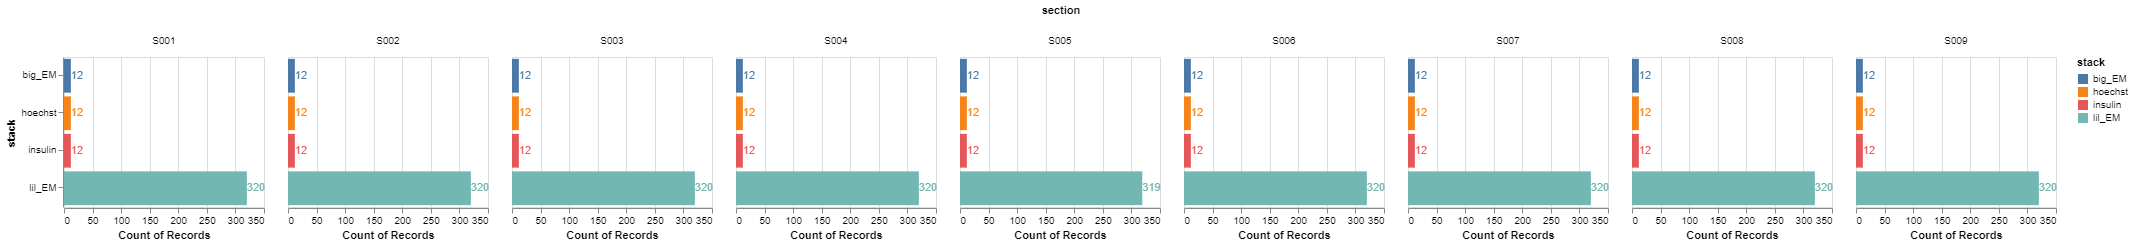

In [6]:
# Make tile count DataFrame for plotting / display purposes
df_tilecount = df_tiles.loc[:, ['section', 'stack', 'z']]
bars = alt.Chart(df_tilecount).mark_bar().encode(
    x='count()',
    y='stack:N',
    color='stack:N',
)

text = bars.mark_text(
    align='left',
    baseline='middle'
).encode(
    text='count()'
)

alt.layer(bars, text, data=df_tilecount).properties(
    width=200,
    height=150,
).facet(
    column='section:N'
)

## Refine image tile DataFrame
---

### `tileId` - add alphanumeric prefix

In [7]:
def gen_prefix(n=3):
    """Generates a sequence of length `n` characters in alphabetical order
    e.g. for n=3 [aaa, aab, aac, ..., zzx, zzy, zzz]
    """
    n = min(n, 4)
    characters = 'abcdefghijklmnopqrstuvwxyz'
    for s in product(characters, repeat=n):
        yield ''.join(s)

In [8]:
# Group by tileset
tilesets = []
for (stack, z), tileset in df_tiles.groupby(['stack', 'z']):
    
    # Sort by acquisition time such that top entry is last acquired
    tileset = tileset.sort_values('acqTime', ascending=False)\
                     .reset_index(drop=True).copy()
    
    # Prepend alphanumeric prefix to each tileId
    prefixes = pd.Series(gen_prefix())[:len(tileset)]
    tileset['tileId'] = prefixes + '_' + tileset['tileId']
    tilesets.append(tileset)
    
# Update image tile DataFrame
df_tiles = pd.concat(tilesets).reset_index(drop=True)
# Preview
df_tiles.groupby(['stack'])\
        .apply(lambda x: x.head(3))[preview_cols]

z section  imageRow  imageCol      stageX       stageY  width  \
stack                                                                        
big_EM  0    1    S001         3         0 -954.430000  5906.398000   4096   
        1    1    S001         3         1 -763.989000  5906.401000   4096   
        2    1    S001         3         2 -573.547000  5906.478000   4096   
hoechst 108  1    S001         3         0 -951.984544  5905.630277   2048   
        109  1    S001         3         1 -761.187101  5905.677940   2048   
        110  1    S001         3         2 -570.443158  5905.827960   2048   
insulin 216  1    S001         3         0 -951.984544  5905.630277   2048   
        217  1    S001         3         1 -761.187101  5905.677940   2048   
        218  1    S001         3         2 -570.443158  5905.827960   2048   
lil_EM  324  1    S001        19         0 -809.153000  6049.631000   4096   
        325  1    S001        19         1 -791.563000  6049.626000   4096   
        326  1    S001        19         2 -774.143000  6049.629000   4096   

             height   pixelsize               tileId             acqTime  
stack                                                                     
big_EM  0      4096   33.566317  aaa_big_EM-S001-... 2019-11-02 14:04:30  
        1      4096   33.566317  aab_big_EM-S001-... 2019-11-02 14:02:40  
        2      4096   33.566317  aac_big_EM-S001-... 2019-11-02 14:00:51  
hoechst 108    2048  106.356298  aaa_hoechst-S001... 2019-11-02 14:04:22  
        109    2048  106.337112  aab_hoechst-S001... 2019-11-02 14:02:33  
        110    2048  106.321854  aac_hoechst-S001... 2019-11-02 14:00:43  
insulin 216    2048  106.356298  aaa_insulin-S001... 2019-11-02 14:04:26  
        217    2048  106.337112  aab_insulin-S001... 2019-11-02 14:02:37  
        218    2048  106.321854  aac_insulin-S001... 2019-11-02 14:00:47  
lil_EM  324    4096    4.859737  aaa_lil_EM-S001-... 2019-11-03 01:43:53  
        325    4096    4.859737  aab_lil_EM-S001-... 2019-11-03 01:42:44  
        326    4096    4.859737  aac_lil_EM-S001-... 2019-11-03 01:41:34

### `tforms` - set affine transformations
Place image tiles in `render` coordinate space (aka pixel space) such that top left image tile in each tileset has its center at (0, 0). This requires 2 (translation-only) transformations
1. Offset by ($-\frac{1}{2}$ `width`, $-\frac{1}{2}$ `height`)
1. Offset by (`stageX`, `stageY`) (stage position converted to pixel space by dividing by pixelsize)

In [10]:
# Iterate through tilesets
for (stack, z), tileset in df_tiles.groupby(['stack', 'z']):

    # 1) Offset by (-1/2 width, -1/2 height)
    # --------------------------------------
    x1 = -tileset['width'] / 2
    y1 = -tileset['height'] / 2    

    # 2) Offset by stage position
    # ---------------------------
    # Normalize to (0, 0) since Odemis stage position is basically random
    x2 = tileset['stageX'] - tileset['stageX'].min()
    y2 = tileset['stageY'] - tileset['stageY'].min()
    # Divide by pixelsize and flip y axis
    x2 =  x2 / (tileset['pixelsize']/1e3)  # um / (um/px) = px
    y2 = -y2 / (tileset['pixelsize']/1e3)  # um / (um/px) = px
    # Shift y translation up so that it's all positivo
    y2 -= y2.min()

    # Add `render` affine transformations to DataFrame
    # ------------------------------------------------
    # Create `render` affine transformations
    T1 = [[AffineRender(B0=x, B1=y)] for x, y in zip(x1, y1)]
    T2 = [[AffineRender(B0=x, B1=y)] for x, y in zip(x2, y2)]
    # Add to DataFrame
    df_tiles.loc[(df_tiles['stack'] == stack) &\
                 (df_tiles['z'] == z),
                 'tforms'] = list(zip(T1, T2))

# Unpack tforms
df_tiles['tforms'] = df_tiles['tforms'].apply(lambda x: [x[i][0] for i in range(len(x))])
# Preview
df_tiles.groupby('stack')\
        .apply(lambda x: x.sample(3))[preview_cols + ['tforms']]

z section  imageRow  imageCol       stageX       stageY  width  \
stack                                                                          
big_EM  103   9    S009         1         1  4021.493000  6361.587000   4096   
        32    3    S003         1         2   606.511000  6340.792000   4096   
        8     1    S001         1         2  -573.418000  6295.522000   4096   
hoechst 164   5    S005         1         2  1811.578000  6381.133000   2048   
        205   9    S009         3         1  4022.510491  5971.246754   2048   
        157   5    S005         3         1  1622.734120  5991.236088   2048   
insulin 238   2    S002         0         1  -171.356556  6510.427212   2048   
        269   5    S005         2         0  1431.650257  6186.026784   2048   
        297   7    S007         0         2  3022.404175  6576.811589   2048   
lil_EM  2959  9    S009        15        12  4168.422000  6143.087000   4096   
        1155  3    S003         8         0   372.316000  6280.227000   4096   
        2829  8    S008         3        10  3554.392000  6372.406000   4096   

              height   pixelsize               tileId             acqTime  \
stack                                                                       
big_EM  103     4096   33.566317  aah_big_EM-S009-... 2019-11-02 18:33:15   
        32      4096   33.566317  aai_big_EM-S003-... 2019-11-02 15:06:40   
        8       4096   33.566317  aai_big_EM-S001-... 2019-11-02 13:49:53   
hoechst 164     2048  106.469770  aai_hoechst-S005... 2019-11-02 16:24:29   
        205     2048  106.511225  aab_hoechst-S009... 2019-11-02 18:44:06   
        157     2048  106.404108  aab_hoechst-S005... 2019-11-02 16:37:16   
insulin 238     2048  106.379264  aak_insulin-S002... 2019-11-02 14:32:29   
        269     2048  106.413272  aaf_insulin-S005... 2019-11-02 16:30:02   
        297     2048  106.484682  aaj_insulin-S007... 2019-11-02 17:32:35   
lil_EM  2959    4096    4.859506  acy_lil_EM-S009-... 2019-11-05 21:55:17   
        1155    4096    4.859506  ahj_lil_EM-S003-... 2019-11-03 17:04:19   
        2829    4096    4.859506  akg_lil_EM-S008-... 2019-11-05 11:40:16   

                           tforms  
stack                              
big_EM  103   [M=[[1.000000,0....  
        32    [M=[[1.000000,0....  
        8     [M=[[1.000000,0....  
hoechst 164   [M=[[1.000000,0....  
        205   [M=[[1.000000,0....  
        157   [M=[[1.000000,0....  
insulin 238   [M=[[1.000000,0....  
        269   [M=[[1.000000,0....  
        297   [M=[[1.000000,0....  
lil_EM  2959  [M=[[1.000000,0....  
        1155  [M=[[1.000000,0....  
        2829  [M=[[1.000000,0....

### `minint`, `maxint` - set min, max intensity levels 

#### FM channels
Sample `N` FM image tiles (per section), take histogram and assign min, max intensity levels according to min and max percentile specified

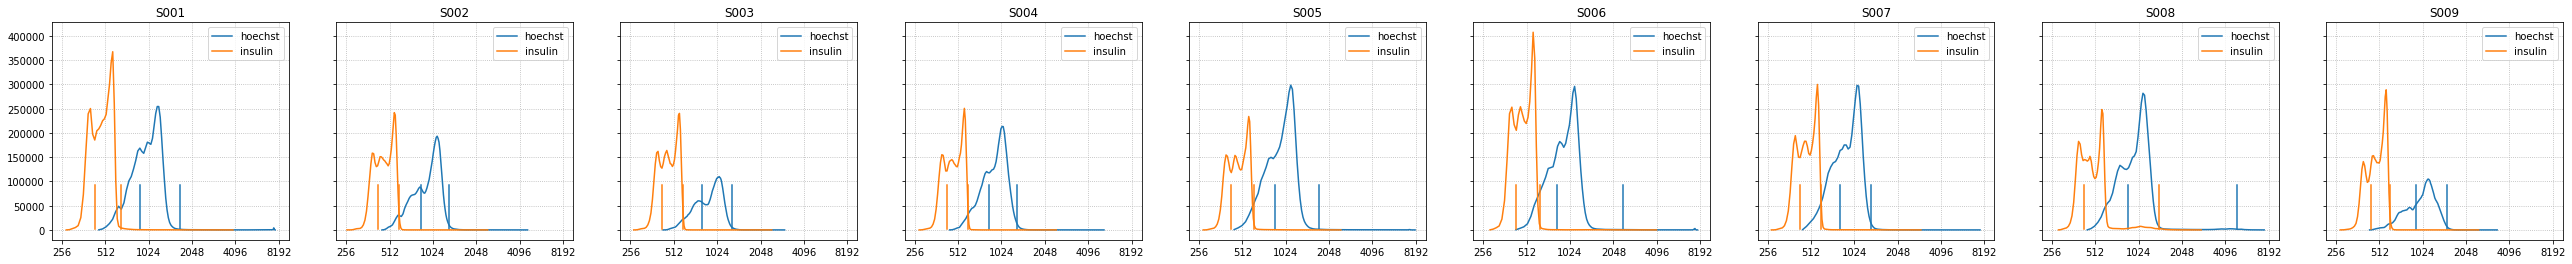

In [11]:
# Parameters
# ----------
N = 10     # Sample size
pct1 = 25  # min %ile
pct2 = 99  # max %ile

# Set up figure
ncols=len(sections)
fig, axes = plt.subplots(ncols=ncols, sharex=True, sharey=True,
                         figsize=(ncols*5, 4))

# Loop through FM stacks
total = len(stacks_FM) * len(sections)
axes_map = {k: v for k, v in zip(sections, axes.flat)}
cmap = {k: v for k, v in zip(stacks_FM, sns.color_palette(n_colors=len(stacks_FM)))}
for i, ((stack, section), tileset) in tqdm_notebook(enumerate(df_tiles.loc[df_tiles['stack'].isin(stacks_FM)]\
                                                                      .groupby(['stack', 'section'])), total=total):
    # Choose random sample
    fps = tileset.sample(n=min(N, len(tileset)))['imageUrl']

    # Loop through sample image tiles
    images = []
    for fp in fps:

        # Accumulate images
        image = imread(fp.split('://')[1])
        images.append(image)

    # Take histograms
    mean = np.mean(images, axis=0)
    hist, bin_centers = histogram(mean)
    p1, p2 = np.percentile(mean, (pct1, pct2))

    # Set min, max intensity
    df_tiles.loc[(df_tiles['stack'] == stack) &\
                 (df_tiles['section'] == section),
                 ['minint', 'maxint']] = int(p1), 2*int(p1)

    # Plot
    ax = axes_map[section]
    color = cmap[stack]
    ax.plot(bin_centers, hist, color=color, label=stack)
    [ax.axvline(p, ymin=0.05, ymax=0.25, color=color) for p in [p1, p2]]
    # Aesthetics
    ax.set_title(section)
    ax.set_xscale('symlog', basex=2)
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.legend()
    ax.grid(ls=':')

#### EM channels
Sample `N` FM image tiles (per section), take histogram and assign min, max intensity levels according to min and max percentile specified

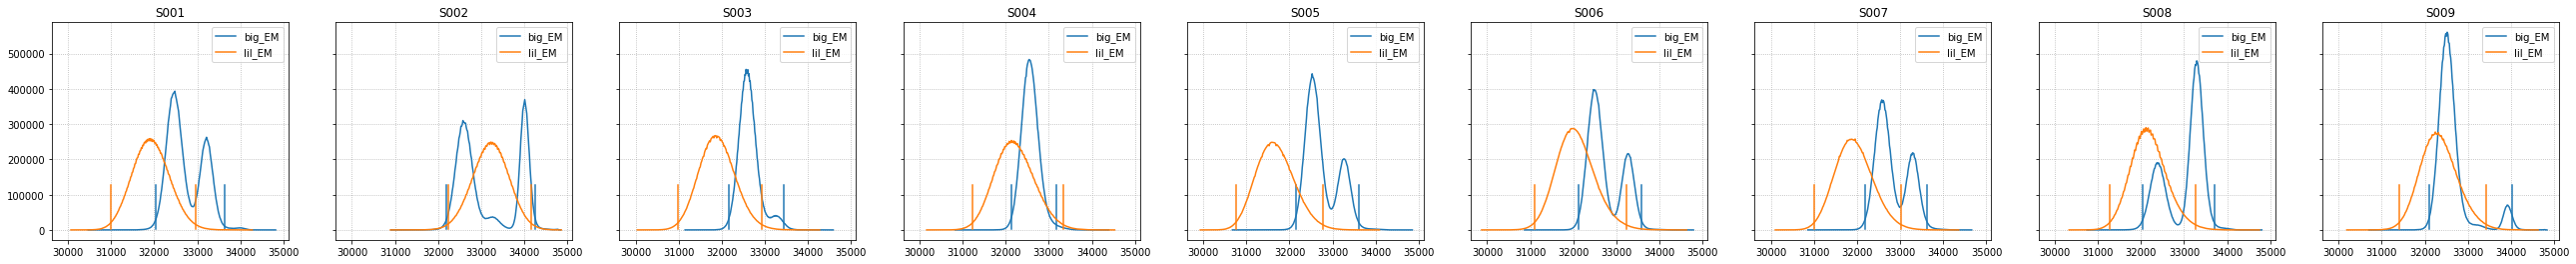

In [12]:
# Parameters
# ----------
N = 3     # Sample size
pct1 = 1   # min %ile
pct2 = 99  # max %ile

# Set up figure
ncols=len(sections)
fig, axes = plt.subplots(ncols=ncols, sharex=True, sharey=True,
                         figsize=(ncols*5, 4))

# Loop through EM stacks
total = len(stacks_EM) * len(sections)
axes_map = {k: v for k, v in zip(sections, axes.flat)}
cmap = {k: v for k, v in zip(stacks_EM, sns.color_palette(n_colors=len(stacks_EM)))}
for i, ((stack, section), tileset) in tqdm_notebook(enumerate(df_tiles.loc[df_tiles['stack'].isin(stacks_EM)]\
                                                                      .groupby(['stack', 'section'])), total=total):
    # Choose random sample
    fps = tileset.sample(n=min(N, len(tileset)))['imageUrl']

    # Loop through sample image tiles
    images = []
    for fp in fps:

        # Accumulate images
        image = imread(fp.split('://')[1])
        images.append(image)

    # Take histograms
    mean = np.mean(images, axis=0)
    hist, bin_centers = histogram(mean)
    p1, p2 = np.percentile(mean, (pct1, pct2))

    # Set min, max intensity
    df_tiles.loc[(df_tiles['stack'] == stack) &\
                 (df_tiles['section'] == section),
                 ['minint', 'maxint']] = int(p1), int(p2)

    # Plot
    ax = axes_map[section]
    color = cmap[stack]
    ax.plot(bin_centers, hist, color=color, label=stack)
    [ax.axvline(p, ymin=0.05, ymax=0.25, color=color) for p in [p1, p2]]
    # Aesthetics
    ax.set_title(section)
    ax.legend()
    ax.grid(ls=':')

#### Optionally overwrite min, max intensity levels

In [13]:
# # Specify stack and section(s)
# stack_ = 'insulin'
# sections_ = sections

# df_tiles.loc[(df_tiles['stack'] == stack_) &\
#              (df_tiles['section'].isin(sections_)),
#              ['minint', 'maxint']] = 500, 1000

In [14]:
# Preview
df_tiles.groupby('stack')\
        .apply(lambda x: x.sample(3))[preview_cols + ['minint', 'maxint']]

z section  imageRow  imageCol       stageX       stageY  width  \
stack                                                                          
big_EM  103   9    S009         1         1  4021.493000  6361.587000   4096   
        15    2    S002         2         2    16.428000  6120.927000   4096   
        73    7    S007         3         1  2831.410000  5992.228000   4096   
hoechst 183   7    S007         2         2  3022.835602  6186.680021   2048   
        120   2    S002         3         0  -360.917125  5925.803454   2048   
        203   8    S008         0         0  3256.032445  6576.371986   2048   
insulin 267   5    S005         2         2  1812.938401  6186.266924   2048   
        323   9    S009         0         0  3831.261353  6556.466992   2048   
        219   1    S001         2         2  -570.832426  6100.562355   2048   
lil_EM  1839  5    S005         5        12  1781.337000  6360.815000   4096   
        2645  8    S008        14        13  3606.342000  6179.838000   4096   
        3161  9    S009         2         9  4115.254000  6370.767000   4096   

              height   pixelsize               tileId             acqTime  \
stack                                                                       
big_EM  103     4096   33.566317  aah_big_EM-S009-... 2019-11-02 18:33:15   
        15      4096   33.566317  aad_big_EM-S002-... 2019-11-02 14:45:21   
        73      4096   33.566317  aab_big_EM-S007-... 2019-11-02 17:47:16   
hoechst 183     2048  106.452477  aad_hoechst-S007... 2019-11-02 17:43:29   
        120     2048  106.356062  aaa_hoechst-S002... 2019-11-02 14:50:42   
        203     2048  106.496025  aal_hoechst-S008... 2019-11-02 17:57:14   
insulin 267     2048  106.412358  aad_insulin-S005... 2019-11-02 16:33:41   
        323     2048  106.547846  aal_insulin-S009... 2019-11-02 18:25:53   
        219     2048  106.348664  aad_insulin-S001... 2019-11-02 13:58:57   
lil_EM  1839    4096    4.859506  ajb_lil_EM-S005-... 2019-11-04 10:07:55   
        2645    4096    4.859506  ade_lil_EM-S008-... 2019-11-05 15:15:22   
        3161    4096    4.859506  aks_lil_EM-S009-... 2019-11-05 17:59:26   

              minint  maxint  
stack                         
big_EM  103    32113   34037  
        15     32196   34256  
        73     32193   33620  
hoechst 183      817    1634  
        120      844    1688  
        203      865    1730  
insulin 267      429     858  
        323      445     890  
        219      432     864  
lil_EM  1839   30764   32772  
        2645   31278   33263  
        3161   31408   33425

## Import image tiles to `render-ws`
---

### Create stacks

In [15]:
# Iterate through stacks
for stack, df_stack in tqdm_notebook(df_tiles.groupby('stack')):

    # Create `TileSpec`s
    tile_specs = []
    for i, tile in df_stack.iterrows():
        ts = TileSpec(**tile.to_dict())
        tile_specs.append(ts)

    # Set stack resolution
    Rx = df_stack['pixelsize'].iloc[0]
    Ry = df_stack['pixelsize'].iloc[0]
    Rz = section_thickness

    # Create stack
    renderapi.stack.create_stack(stack,
                                 stackResolutionX=Rx,
                                 stackResolutionY=Ry,
                                 stackResolutionZ=Rz,
                                 render=render)

    # Import TileSpecs to render
    renderapi.client.import_tilespecs(stack,
                                      tile_specs,
                                      render=render)

    # Set stack state to complete
    renderapi.stack.set_stack_state(stack, 'COMPLETE', render=render)

## Inspect stacks
---

### Project DataFrame

In [16]:
# Project DataFrame
df_project = create_project_DataFrame(render=render)
# Preview
df_project.groupby('stack').apply(lambda x: x.sample(3))

tileId    z   width  height  minIntensity  \
stack                                                                  
big_EM  96    aaa_big_EM-S009-...  9.0  4096.0  4096.0       32113.0   
        107   aal_big_EM-S009-...  9.0  4096.0  4096.0       32113.0   
        38    aac_big_EM-S004-...  4.0  4096.0  4096.0       32127.0   
hoechst 11    aal_hoechst-S001...  1.0  2048.0  2048.0         891.0   
        67    aah_hoechst-S006...  6.0  2048.0  2048.0         836.0   
        80    aai_hoechst-S007...  7.0  2048.0  2048.0         817.0   
insulin 69    aaj_insulin-S006...  6.0  2048.0  2048.0         433.0   
        12    aaa_insulin-S002...  2.0  2048.0  2048.0         423.0   
        66    aag_insulin-S006...  6.0  2048.0  2048.0         433.0   
lil_EM  2308  acr_lil_EM-S008-...  8.0  4096.0  4096.0       31278.0   
        900   aka_lil_EM-S003-...  3.0  4096.0  4096.0       30990.0   
        1870  akl_lil_EM-S006-...  6.0  4096.0  4096.0       31108.0   

              maxIntensity    stack sectionId               camera  imageRow  \
stack                                                                          
big_EM  96         34037.0   big_EM      S009            pcie-6251         3   
        107        34037.0   big_EM      S009            pcie-6251         0   
        38         33182.0   big_EM      S004            pcie-6251         3   
hoechst 11          1782.0  hoechst      S001  Andor ZYLA-4.2P-...         0   
        67          1672.0  hoechst      S006  Andor ZYLA-4.2P-...         1   
        80          1634.0  hoechst      S007  Andor ZYLA-4.2P-...         1   
insulin 69           866.0  insulin      S006  Andor ZYLA-4.2P-...         0   
        12           846.0  insulin      S002  Andor ZYLA-4.2P-...         3   
        66           866.0  insulin      S006  Andor ZYLA-4.2P-...         1   
lil_EM  2308       33263.0   lil_EM      S008            pcie-6251        15   
        900        32930.0   lil_EM      S003            pcie-6251         3   
        1870       33227.0   lil_EM      S006            pcie-6251         3   

              imageCol       stageX       stageY             imageUrl  temca  
stack                                                                         
big_EM  96           0  3831.122000  5972.378000  file:///long_ter...  SECOM  
        107          0  3831.134000  6556.207000  file:///long_ter...  SECOM  
        38           2  1211.599000  5981.998000  file:///long_ter...  SECOM  
hoechst 11           0  -953.470160  6490.093887  file:///long_ter...  SECOM  
        67           1  2227.808609  6381.567861  file:///long_ter...  SECOM  
        80           2  3022.650149  6381.736834  file:///long_ter...  SECOM  
insulin 69           2  2418.121563  6576.879485  file:///long_ter...  SECOM  
        12           0  -360.917125  5925.803454  file:///long_ter...  SECOM  
        66           0  2037.222002  6381.338217  file:///long_ter...  SECOM  
lil_EM  2308         5  3466.851000  6162.399000  file:///long_ter...    NaN  
        900          4   442.643000  6367.457000  file:///long_ter...    NaN  
        1870        15  2443.196000  6398.953000  file:///long_ter...    NaN

### Map out tiles

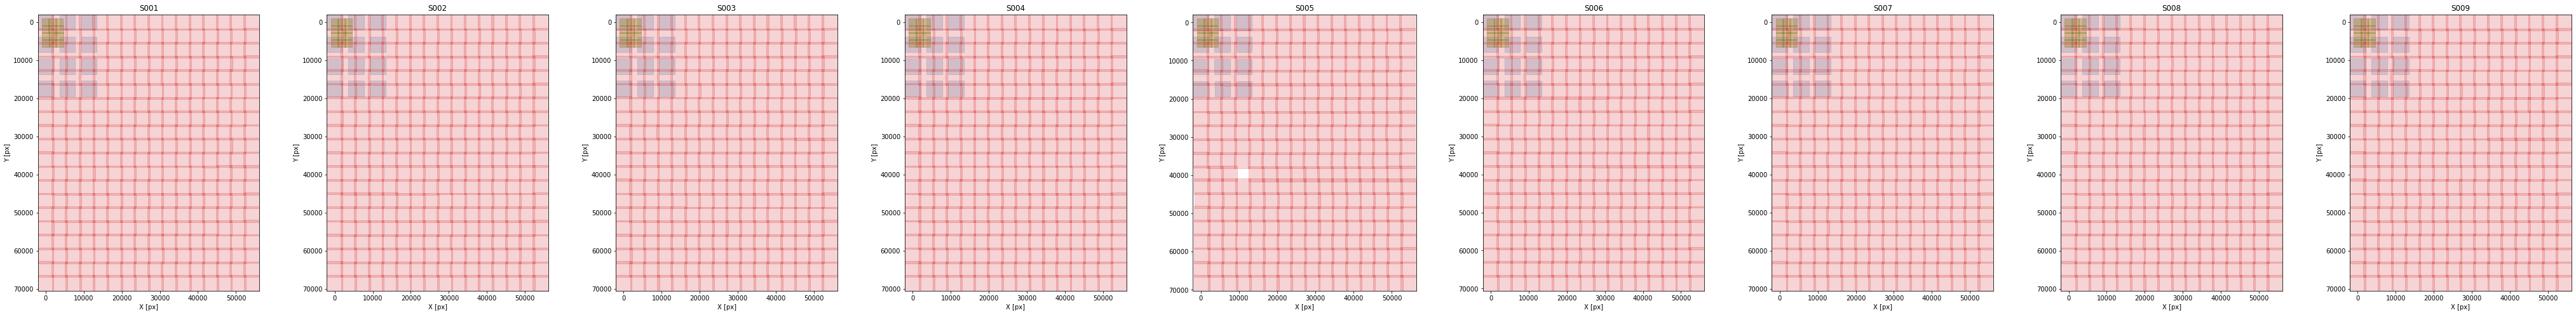

In [17]:
# Create tilemap DataFrame
# ------------------------
df_tilemap = create_tilemap_DataFrame(render=render)

# Set up figure
# -------------
ncols = len(sections)
fig, axes = plt.subplots(ncols=ncols, figsize=(8*ncols, 8))
axes_map = {k: v for k, v in zip(sections, axes.flat)}
cmap = {k: v for k, v in zip(stacks, sns.color_palette(n_colors=len(stacks)))}

# Iterate through layers
for sectionId, layer in df_tilemap.groupby('sectionId'):
    # Collect all tiles in each layer to determine bounds
    boxes = []
    # Set axis
    ax = axes_map[sectionId]

    # Loop through tilesets within each layer
    for stack, tileset in layer.groupby('stack'):

        # Loop through each tile
        for i, tile in tileset.iterrows():

            # Create `shapely.box` resembling raw image tile
            b = box(0, 0, tile['width'], tile['height'])
            # Apply transforms to `shapely.box`
            b = affinity.affine_transform(b, tile['T0'])
            b = affinity.affine_transform(b, tile['T1'])
            boxes.append(b)
            # Get coordinates of `shapely.box` to plot matplotlib polygon patch
            xy = np.array(b.exterior.xy).T
            p = Polygon(xy, color=cmap[stack], alpha=0.2)
            ax.add_patch(p)

    # Axis aesthetics
    ax.set_title(sectionId)
    ax.set_xlabel('X [px]')
    ax.set_ylabel('Y [px]')
    # Determine bounds
    bounds = np.swapaxes([b.exterior.xy for b in boxes], 1, 2).reshape(-1, 2)
    ax.set_xlim(bounds[:, 0].min(), bounds[:, 0].max())
    ax.set_ylim(bounds[:, 1].min(), bounds[:, 1].max())
    ax.invert_yaxis()
    ax.set_aspect('equal')

### Render images